In [123]:
import numpy as np
import matplotlib.pyplot as plt
from pydmd import DMD
from pydmd.plotter import plot_eigs, plot_summary

### Tratamento de dados

Carregando os dados

In [124]:
# load npz
data = np.load('data/data_bubble.npz')
data

NpzFile 'data/data_bubble.npz' with keys: data

In [125]:
D = data['data']

In [126]:
D.shape

AttributeError: 'NpzFile' object has no attribute 'shape'

81 snapshots de dimensão (201, 201). Cada ponto de um snapshot é tridimensional.

[image.py:701 - _normalize_image_array() ] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


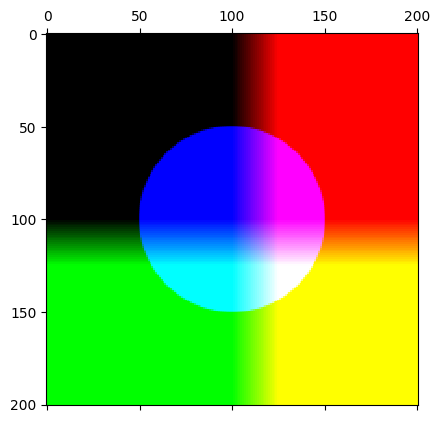

In [ ]:
# plotando uma snapshot
plt.matshow(D[:, :, 0])

A parte tridimensional parece ser ruído...

Verificando...

In [ ]:
print(D[:, :, 0][0, 0][2], D[:, :, 0][100, 100][2])

0.0 1.0


Mantendo apenas a terceira coluna, binária.

In [ ]:
D = D[:, :, :, 2:3]
D.shape

(201, 201, 81, 1)

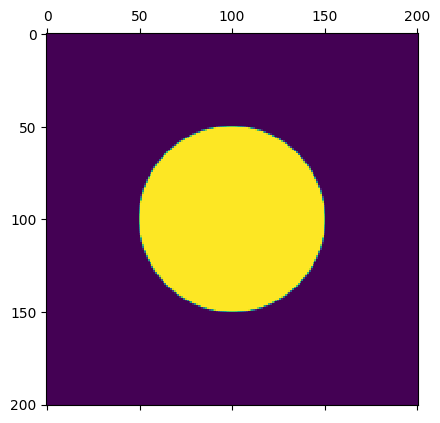

In [ ]:
# replotando
plt.matshow(D[:, :, 0])

Mesmo não sendo 100% binário, é o suficiente.

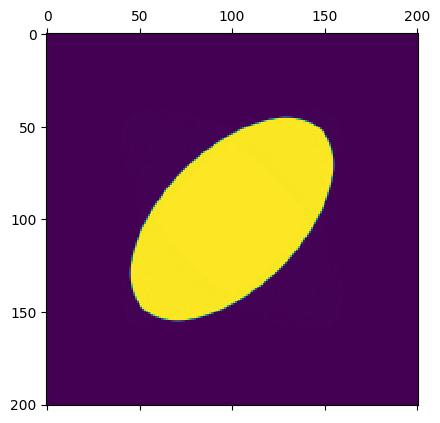

In [ ]:
plt.matshow(D[:, :, 50])

Simplificando...

In [ ]:
D = np.squeeze(D)
D.shape

(201, 201, 81)

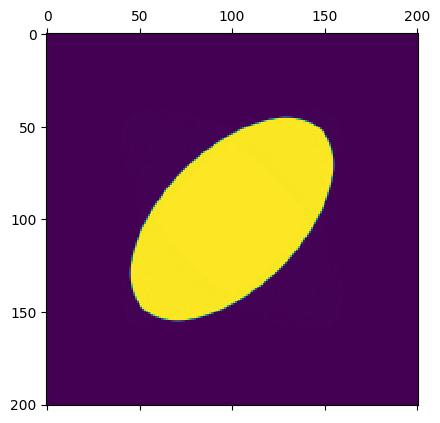

In [ ]:
plt.matshow(D[:, :, 50])

Tudo certo! Partimos daqui.

### Plots

In [ ]:
D.shape

(201, 201, 81)

### DMD

In [ ]:
D.shape

(201, 201, 81)

In [ ]:
# reshape para 2D
D_rs = D.reshape(201*201, 81)
D_rs.shape

(40401, 81)

In [ ]:
# exact DMD from pydmd
dmd = DMD(svd_rank=2, exact=True, opt=True)

In [ ]:
dmd.fit(D_rs.T)

f:\Documentos\Unesp\TCC\data-driven-dynamics\env\Lib\site-packages\pydmd\plotter.py:602: UserWarning: Provided dmd model has less than 3 modes.Plotting all available modes.
  warnings.warn(


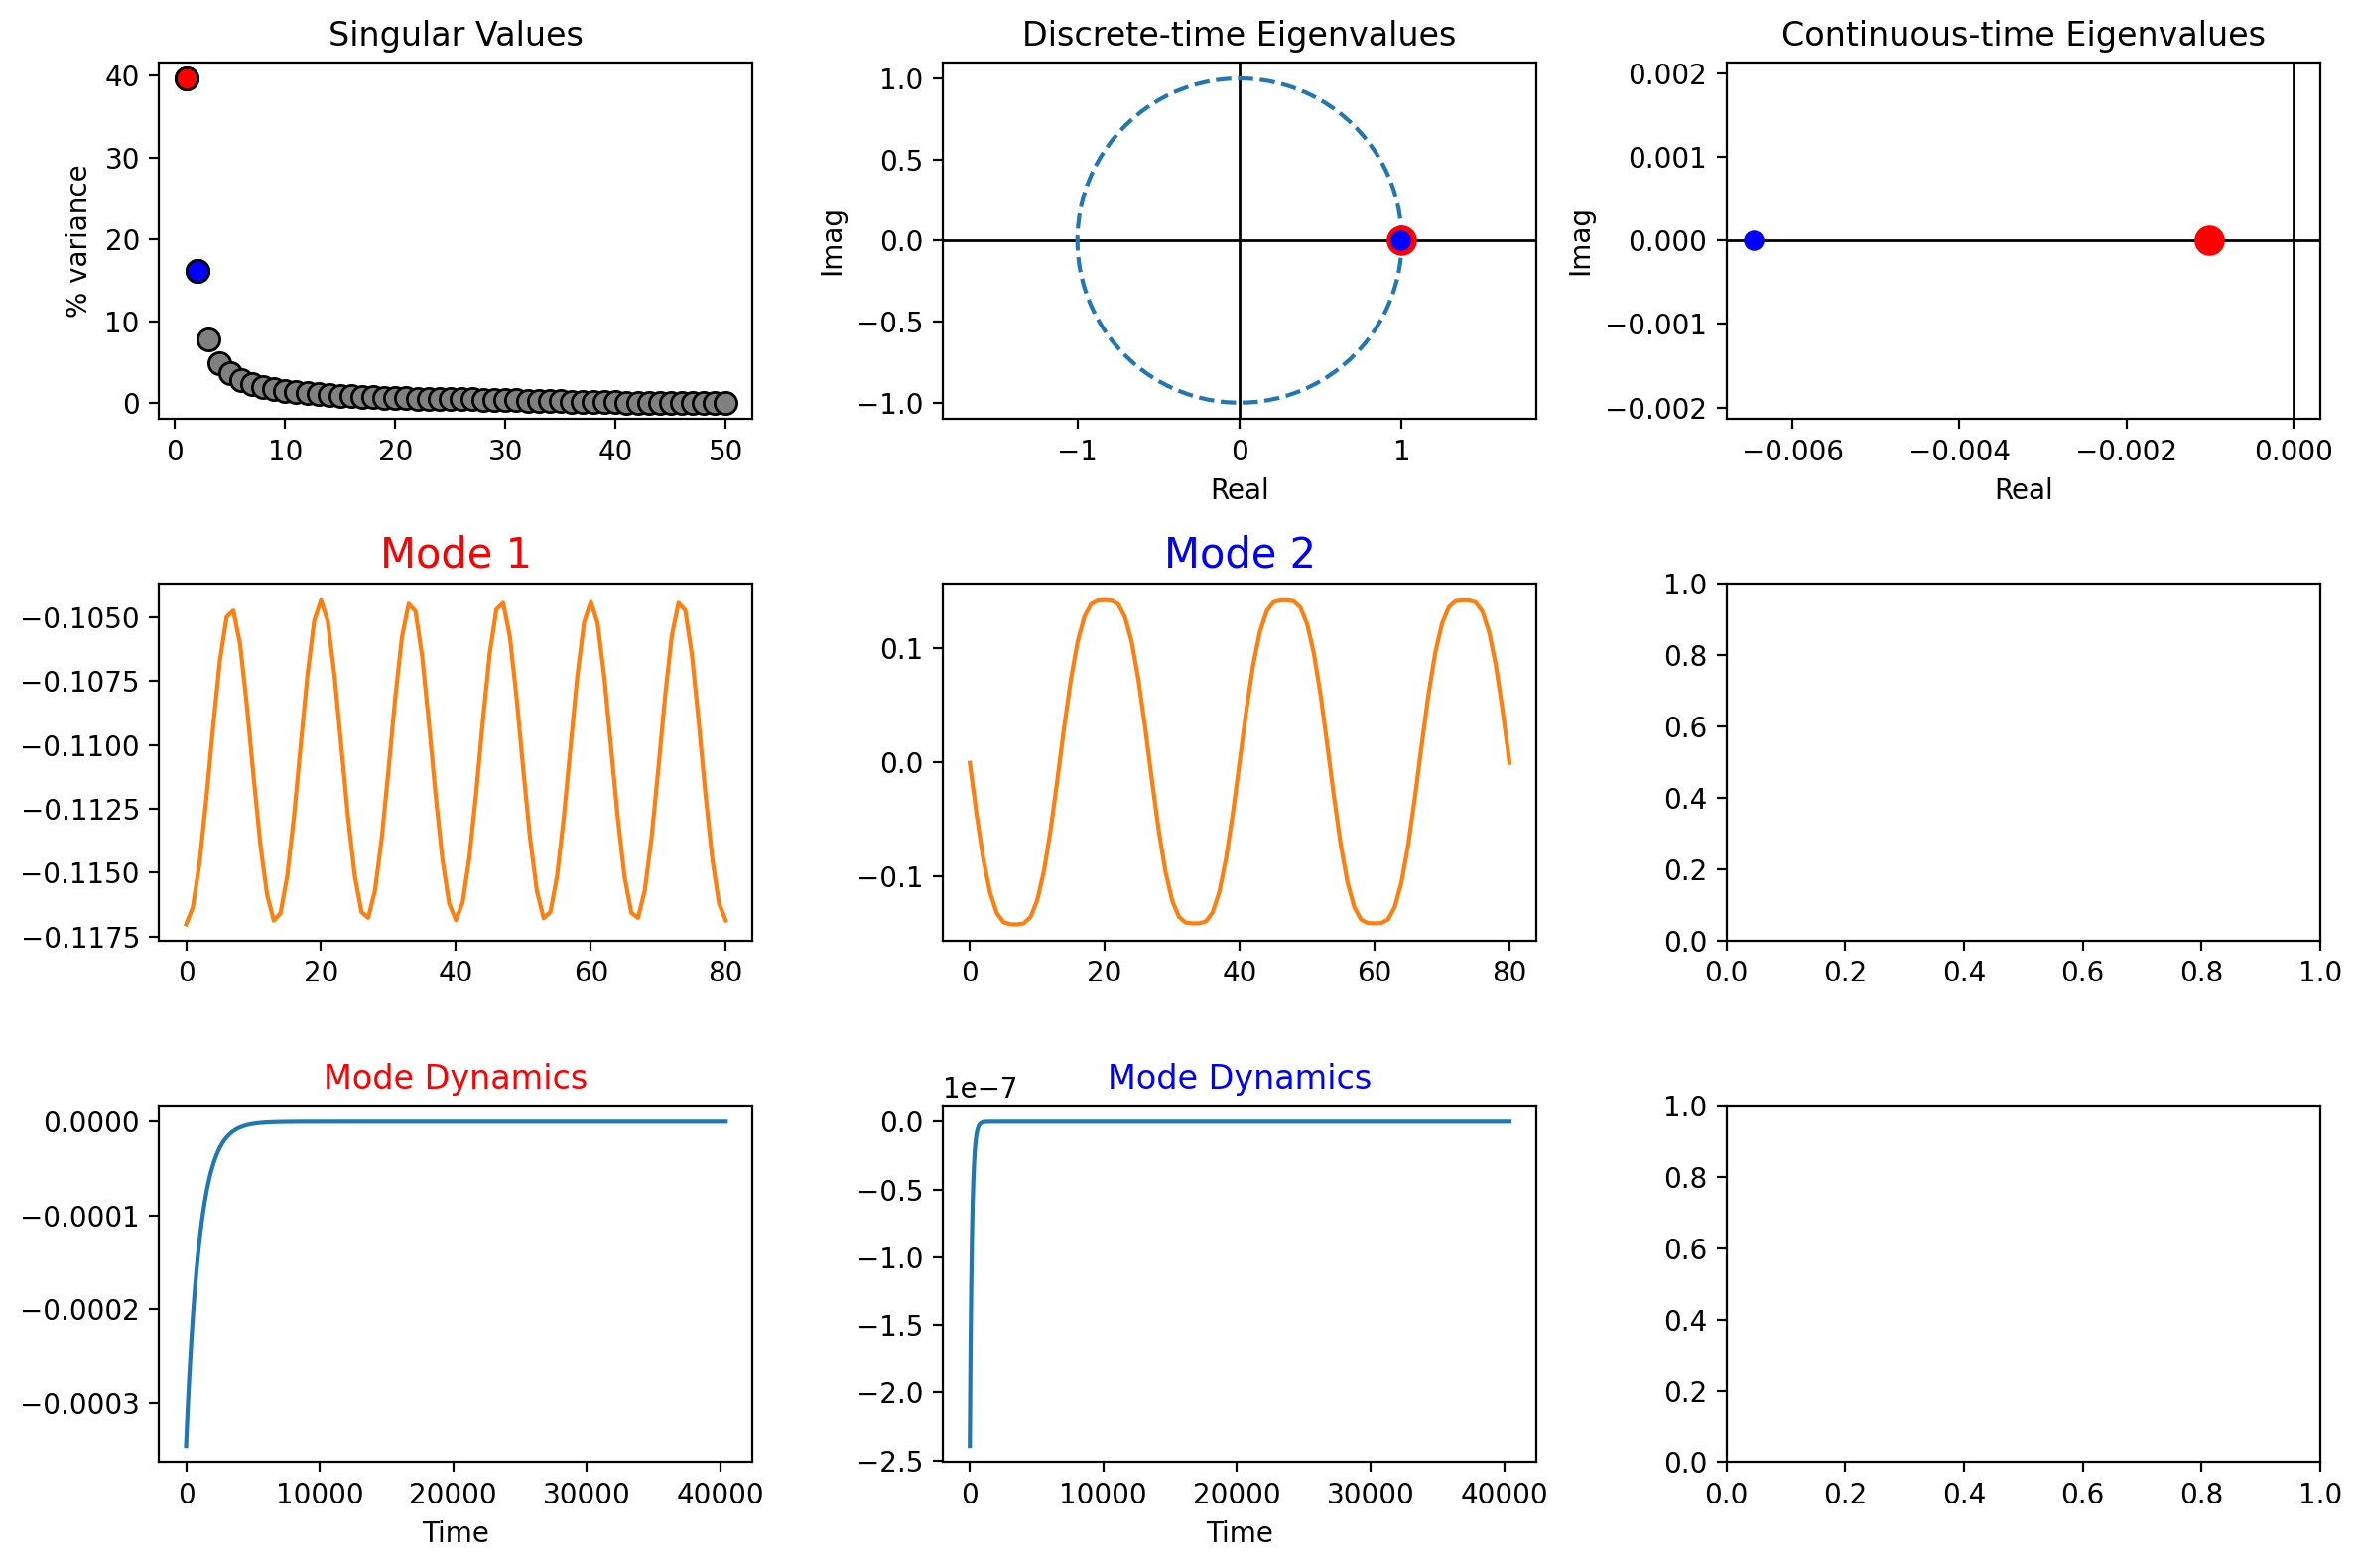

In [ ]:
plot_summary(dmd)